## Create 1D simulation of particles and calculate net magnetization

In [33]:
import numpy as np, matplotlib.pyplot as plt
from joblib import Parallel, delayed

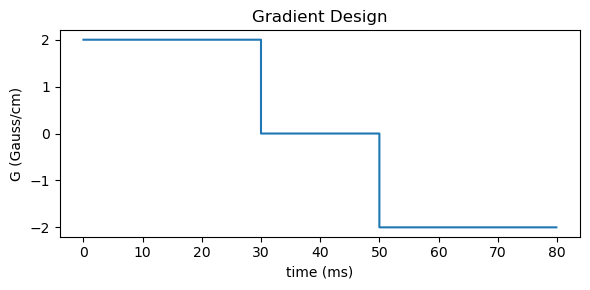

In [76]:
def make_pgse_gradient(dt=1.0, n_delta=50, n_gap=100, G_amp=0.02, gamma=1.0):
    """
    Create a simple PGSE gradient waveform:
    - +G_amp for n_delta steps
    - 0 for n_gap steps
    - -G_amp for n_delta steps

    Returns
    -------
    t        : (n_total,) time array
    G        : (n_total,) gradient array
    dt       : time step (sim units)
    delta    : pulse duration (sim time units)
    big_delta: time between leading edges of the two pulses (sim time units)
    gamma    : gyromagnetic ratio (sim units)
    """
    # Number of steps between leading edges of pulses:
    n_big_delta = n_delta + n_gap              # steps between pulse starts
    n_total = n_big_delta + n_delta           # total steps until end of 2nd pulse

    t = np.arange(n_total) * dt
    G = np.zeros(n_total)

    # First pulse: +G_amp from t=0 to t=n_delta*dt
    G[0:n_delta] = G_amp

    # Second pulse: -G_amp starting at t = n_big_delta*dt
    G[n_big_delta:n_big_delta + n_delta] = -G_amp

    delta = n_delta * dt              # duration of each pulse
    big_delta = n_big_delta * dt      # time between pulse starts (Δ)

    return t, G, dt, delta, big_delta, gamma

# # Example: make and plot a gradient
# t, G, dt, delta, big_delta, gamma = make_pgse_gradient()

# plt.figure(figsize=(6, 3))
# plt.step(t, G, where="post")
# plt.xlabel("time (sim units)")
# plt.ylabel("G(t) (sim units)")
# plt.title("PGSE Gradient Waveform")
# plt.tight_layout()
# plt.show()

G_amp = 2.0      # Gauss/cm  
n_spins = 50000    # number of spin particles
n_delta = 300    # number of dt for pulse
n_gap = 200      # number of dt for gap. n_big_delta = n_spins + n_gap
dt = 0.1         # miliseconds, or 100 microseconds
gamma = 26.75      # rad/(ms*Gauss)

t, G, dt, delta, big_delta, gamma = make_pgse_gradient(dt=dt, n_delta=n_delta, n_gap=n_gap, G_amp=G_amp, gamma=gamma)

plt.figure(figsize=(6, 3))
plt.step(t, G, where="post")
plt.xlabel("time (ms)")
plt.ylabel("G (Gauss/cm)")
plt.title("Gradient Design")
plt.tight_layout()
plt.show()

In [81]:
def plot_diffusion_checks(t, msd, x_snapshot, snapshot_time):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    ax.hist(x_snapshot, bins=50, density=True, alpha=0.7, label="Simulation")

    mu = np.mean(x_snapshot)
    var = np.mean((x_snapshot - mu) ** 2)
    xs = np.linspace(x_snapshot.min(), x_snapshot.max(), 200)
    pdf = 1.0 / np.sqrt(2 * np.pi * var) * np.exp(-(xs - mu) ** 2 / (2 * var))
    ax.plot(xs, pdf, "r-", lw=2, label="Gaussian fit")

    ax.set_title(f"Position distribution at t = {snapshot_time:.2f}")
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("Probability density")
    ax.legend()

    ax = axes[1]
    ax.plot(t, msd, "o-")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel(r"MSD = $\langle x^2 \rangle$ (cm^2)")
    ax.set_title("Mean squared displacement vs time")

    fig.tight_layout()
    plt.show()


def simulate_diffusion_signal(
    D=0.001,          # diffusion coefficient in sim units
    n_spins=50000,    # number of random walkers
    G_amp=0.02,       # gradient amplitude (sim units)
    n_delta=50,
    n_gap=100,
    dt=1.0,
    gamma=1.0,
    seed=0,
    L=None,
    check=False,
):
    if seed is not None:
        np.random.seed(seed)

    t, G, dt, delta, big_delta, gamma = make_pgse_gradient(
        dt=dt, n_delta=n_delta, n_gap=n_gap, G_amp=G_amp, gamma=gamma
    )
    n_total = len(t)

    x = np.zeros(n_spins)
    phi = np.zeros(n_spins)

    step_sigma = np.sqrt(2 * D * dt)

    if check:
        msd = np.zeros(n_total)
        snapshot_idx = n_total - 1
        x_snapshot = None

    for k in range(n_total):
        x += step_sigma * np.random.randn(n_spins)

        if L is not None:
            left, right = -L / 2, L / 2
            x[x < left] = 2 * left - x[x < left]
            x[x > right] = 2 * right - x[x > right]

        if check:
            msd[k] = np.mean(x ** 2)
            if k == snapshot_idx:
                x_snapshot = x.copy()

        phi += gamma * G[k] * x * dt

    if check:
        plot_diffusion_checks(t, msd, x_snapshot, t[snapshot_idx])

    S_sim = np.mean(np.exp(1j * phi))
    S_mag_sim = np.abs(S_sim)

    b_value = (gamma**2) * (G_amp**2) * (delta**2) * (big_delta - delta / 3.0)
    S_ST = np.exp(-b_value * D)

    return S_sim, S_mag_sim, S_ST, b_value, t, G, D, delta, big_delta

### Real physical values

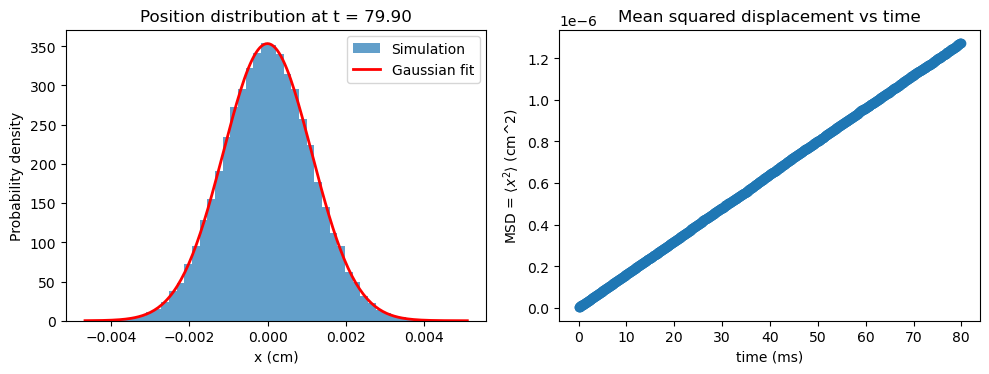

Simulation parameters (real values):
  D       = 8e-09
  G_amp   = 2.0
  delta   = 30.0
  Delta   = 50.0
  b       = 1030.41

Simulated complex signal S_sim = (0.4386981011849354+0.0018972893721443205j)
|S_sim| (sim)   = 0.4387
|S_ST| (theory) = 0.4385
Relative error  = 0.04%


In [82]:
# Example parameters (all in sim units)
D = 8e-9         # cm^2/ms
G_amp = 2.0      # Gauss/cm  
n_spins = 50000    # number of spin particles
n_delta = 300    # number of dt for pulse
n_gap = 200      # number of dt for gap. n_big_delta = n_spins + n_gap
dt = 0.1         # miliseconds, or 100 microseconds
gamma = 26.75      # rad/(ms*Gauss)
cnv_fct = 1e-5 # conversion factor for b-value


S_sim, S_mag_sim, S_ST, b_value, t, G, D_used, delta, big_delta = simulate_diffusion_signal(
    D=D,
    n_spins=n_spins,
    G_amp=G_amp,
    n_delta=n_delta,
    n_gap=n_gap,
    dt=dt,
    gamma=gamma,
    seed=42,
    check=True
)

print(f"Simulation parameters (real values):")
print(f"  D       = {D_used}")
print(f"  G_amp   = {G_amp}")
print(f"  delta   = {delta}")
print(f"  Delta   = {big_delta}")
print(f"  b       = {b_value * cnv_fct}")
print()
print(f"Simulated complex signal S_sim = {S_sim}")
print(f"|S_sim| (sim)   = {S_mag_sim:.4f}")
print(f"|S_ST| (theory) = {S_ST:.4f}")
print(f"Relative error  = {(S_mag_sim - S_ST)/S_ST:.2%}")

In [ ]:
G_vals = np.linspace(0.0, 5.0, 6)   # 6 gradient amplitudes
sim_mags = []
st_mags = []
b_vals = []

for G_amp in G_vals:
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D, n_spins=n_spins, G_amp=G_amp,
        n_delta=n_delta, n_gap=n_gap, dt=dt, gamma=gamma, seed=0
    )
    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)
    b_vals.append(b_value)

b_vals = np.array(b_vals) * cnv_fct
sim_mags = np.array(sim_mags)
st_mags = np.array(st_mags)

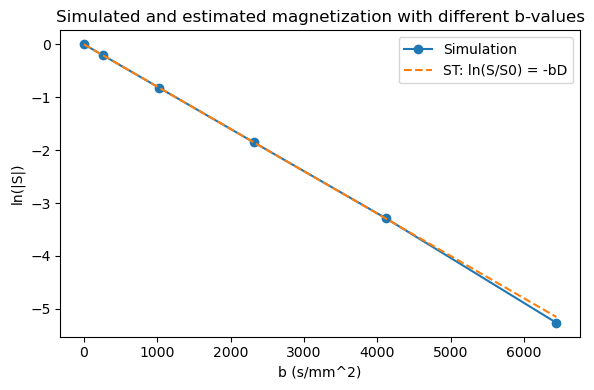

In [70]:
plt.figure(figsize=(6,4))
plt.plot(b_vals, np.log(sim_mags + 1e-12), "o-", label="Simulation")
plt.plot(b_vals, -b_vals * D / cnv_fct, "--", label="ST: ln(S/S0) = -bD")
plt.title("Simulated and estimated magnetization with different b-values")
plt.xlabel("b (s/mm^2)")
plt.ylabel("ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()

### Real physical values with restricted diffusion

In [60]:
D = 8e-9         # cm^2/ms
G_amp = 2.0      # Gauss/cm  
n_spins = 50000    # number of spin particles
n_delta = 300    # number of dt for pulse
n_gap = 200      # number of dt for gap. n_big_delta = n_spins + n_gap
dt = 0.1         # miliseconds, or 100 microseconds
gamma = 26.75      # rad/(ms*Gauss)
L = 0.004 # cm of space length, or equivalently 40 um, about size of a cell
cnv_fct = 1e-5 # convert ms/cm^2 to s/mm^2 for b-value

S_sim, S_mag_sim, S_ST, b_value, t, G, D_used, delta, big_delta = simulate_diffusion_signal(
    D=D,
    n_spins=n_spins,
    G_amp=G_amp,
    n_delta=n_delta,
    n_gap=n_gap,
    dt=dt,
    gamma=gamma,
    seed=42,
    L=L
)

print(f"Simulation parameters (real values):")
print(f"  D       = {D_used}")
print(f"  G_amp   = {G_amp}")
print(f"  delta   = {delta}")
print(f"  Delta   = {big_delta}")
print(f"  b       = {b_value * cnv_fct}")
print()
print(f"Simulated complex signal S_sim = {S_sim}")
print(f"|S_sim| (sim)   = {S_mag_sim:.4f}")
print(f"|S_ST| (theory) = {S_ST:.4f}")
print(f"Relative error  = {(S_mag_sim - S_ST)/S_ST:.2%}")

Simulation parameters (real values):
  D       = 8e-09
  G_amp   = 2.0
  delta   = 30.0
  Delta   = 50.0
  b       = 1030.41

Simulated complex signal S_sim = (0.4777649522953139+0.0020514429844484885j)
|S_sim| (sim)   = 0.4778
|S_ST| (theory) = 0.4385
Relative error  = 8.95%


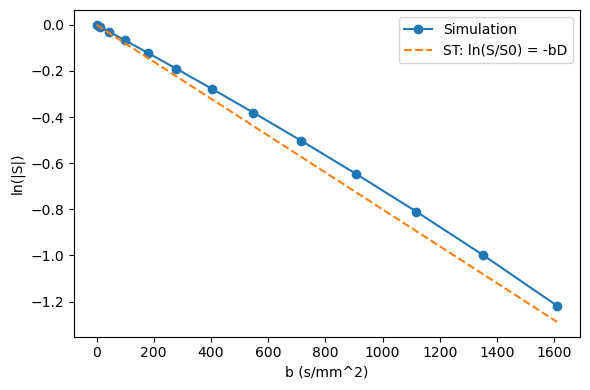

In [79]:
# G_vals = np.linspace(0.0, 5.0, 6)   # 6 gradient amplitudes
G_vals = np.linspace(0.0, 2.5, 13)
sim_mags = []
st_mags = []
b_vals = []
n_spins = 50000

for G_amp in G_vals:
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D, n_spins=n_spins, G_amp=G_amp,
        n_delta=n_delta, n_gap=n_gap, dt=dt, gamma=gamma, seed=0, L = L
    )
    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)
    b_vals.append(b_value)

b_vals = np.array(b_vals) * cnv_fct
sim_mags = np.array(sim_mags)
st_mags = np.array(st_mags)

plt.figure(figsize=(6,4))
# plt.plot(b_vals, -np.log(sim_mags + 1e-12), "o-", label="Simulation")
# plt.plot(b_vals, b_vals * D / cnv_fct, "--", label="ST: -ln(S/S0) = bD")
plt.plot(b_vals, np.log(sim_mags + 1e-12), "o-", label="Simulation")
plt.plot(b_vals, -b_vals * D / cnv_fct, "--", label="ST: ln(S/S0) = -bD")
plt.xlabel("b (s/mm^2)")
plt.ylabel("ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()

**Go further with b-values**

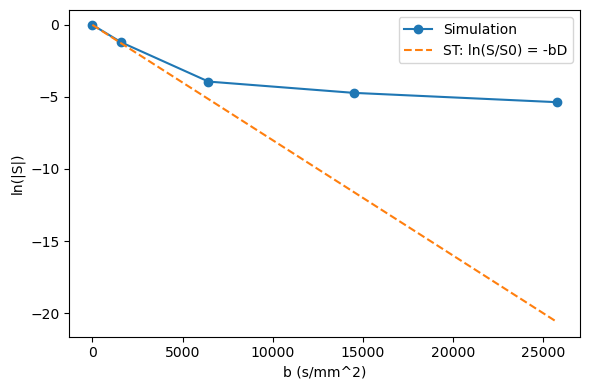

In [42]:
G_vals = np.linspace(0.0, 10.0, 5)
sim_mags = []
st_mags = []
b_vals = []
n_spins = 50000

for G_amp in G_vals:
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D, n_spins=n_spins, G_amp=G_amp,
        n_delta=n_delta, n_gap=n_gap, dt=dt, gamma=gamma, seed=0, L = L
    )
    sim_mags.append(S_mag_sim)
    st_mags.append(S_ST)
    b_vals.append(b_value)

b_vals = np.array(b_vals) * cnv_fct
sim_mags = np.array(sim_mags)
st_mags = np.array(st_mags)

plt.figure(figsize=(6,4))
plt.plot(b_vals, np.log(sim_mags + 1e-12), "o-", label="Simulation")
plt.plot(b_vals, -b_vals * D / cnv_fct, "--", label="ST: ln(S/S0) = -bD")
plt.xlabel("b (s/mm^2)")
plt.ylabel("ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()

### Parallel processing implementation to speed up simulation to allow more particles

In [71]:
G_vals = np.linspace(0.0,10.0,5)

In [54]:
def _run_one_G(idx, G_amp, D, n_spins, n_delta, n_gap, dt, gamma, L, seed):
    S_sim, S_mag_sim, S_ST, b_value, *_ = simulate_diffusion_signal(
        D=D,
        n_spins=n_spins,
        G_amp=G_amp,
        n_delta=n_delta,
        n_gap=n_gap,
        dt=dt,
        gamma=gamma,
        seed=seed,
        L=L,
    )
    return idx, b_value, S_mag_sim, S_ST


def run_parallel_over_G(
    G_vals,
    D,
    n_spins,
    n_delta,
    n_gap,
    dt,
    gamma,
    L,
    base_seed=None,
    n_jobs=-1,  # -1 = use all cores
):
    tasks = []
    for idx, G_amp in enumerate(G_vals):
        seed_i = base_seed + idx if base_seed is not None else None
        tasks.append((idx, G_amp, seed_i))

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(_run_one_G)(
            idx, G_amp,
            D, n_spins, n_delta, n_gap, dt, gamma, L,
            seed
        )
        for (idx, G_amp, seed) in tasks
    )

    # restore original order by idx
    results.sort(key=lambda r: r[0])
    b_vals   = np.array([r[1] for r in results])
    sim_mags = np.array([r[2] for r in results])
    st_mags  = np.array([r[3] for r in results])
    return b_vals, sim_mags, st_mags

In [72]:
b_vals, sim_mags, st_mags = run_parallel_over_G(
    G_vals=G_vals,
    D=D,
    n_spins=1_000_000,
    n_delta=n_delta,
    n_gap=n_gap,
    dt=dt,
    gamma=gamma,
    L=L,
    base_seed=123,
    n_jobs=-1,
)

# now b_vals are in ms/cm^2; convert if needed:
b_vals = b_vals * cnv_fct
lnS_sim = np.log(sim_mags + 1e-12)

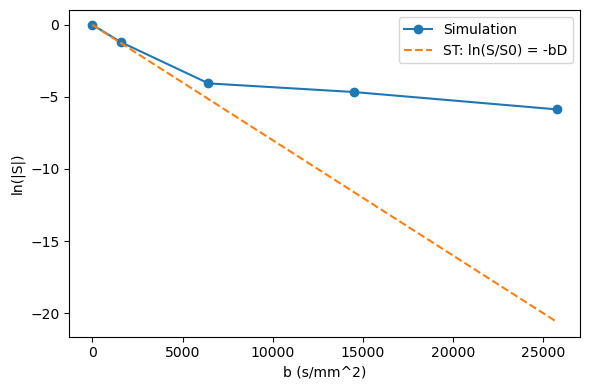

In [73]:
plt.figure(figsize=(6,4))
plt.plot(b_vals, lnS_sim, "o-", label="Simulation")
plt.plot(b_vals, -b_vals * D / cnv_fct, "--", label="ST: ln(S/S0) = -bD")
plt.xlabel("b (s/mm^2)")
plt.ylabel("ln(|S|)")
plt.legend()
plt.tight_layout()
plt.show()